# radial basis function neural networks(RBFNNs)

In [10]:
%matplotlib inline 
from IPython.core.display import display

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from sympy import *
import matplotlib.figure
init_printing()
#from math import *
from interval import interval, inf
from interval import imath
import sys
from pprint import pprint
import datetime
import os

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
import numpy as np
import pandas as pd

## $NN(x_1, x_2) = exp(-4(x_1 - 1)^2  -  6(x_2 - 0.5)^2) + exp(-7(x_1+1.5)^2 - 9(x_2+1)^2)$
where $x_1 \in [-2,2], x_2 \in [-2,2]$

### グラフの可視化

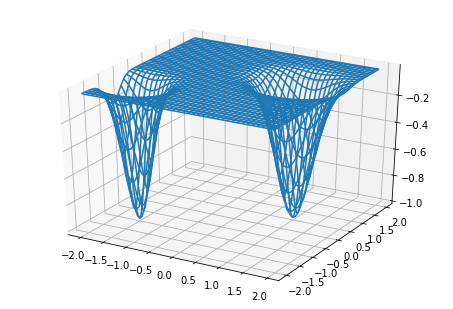

In [2]:
def activate_func(x):
    """
    params:
        x = np.array([x_1, x_2])
    """
    ans = np.exp(-4*((x[0]-1)**2) - 6*((x[1]-0.5)**2)) + \
        np.exp(-7*((x[0]+1.5)**2) - 9*((x[1]+1)**2))
    return -ans
    
x = np.arange(-2, 2, 0.05) 
y = np.arange(-2, 2, 0.05) 

X, Y = np.meshgrid(x, y)
Z = np.apply_along_axis(activate_func, 0, np.array([X.flatten(), Y.flatten()])).reshape(X.shape)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X,Y,Z) 
plt.show()

### Krawczyk method

In [3]:
! echo '' > find_all_solution.out
from ivmat import ivmat as ip
from fmat import fmat
from krawczyk import Krawczyk

In [4]:
x_1, x_2, x_3 = var("x_1 x_2 x_3")
f_x_1 = symbols("f_x_1", cls=Function)
f_x_2 = symbols("f_x_2", cls=Function)
nn = exp(-4*(x_1-1)**2 - 6*(x_2-0.5)**2) + exp(-7*(x_1+1.5)**2 - 9*(x_2+1)**2)
nn = -nn

func_eval = lambda func: (lambda x_1, x_2, exp=imath.exp: eval(str(func)))
f = fmat([[func_eval(nn)]])
df_symbol = [[nn.diff(x_1)],[nn.diff(x_2)]]
df = fmat([[func_eval(nn.diff(x_1))], [func_eval(nn.diff(x_2))]])
hes = hessian(nn, (x_1,x_2))
ddf = fmat([[None for i in range(hes.shape[1])] for j in range(hes.shape[0])])
for i in range(2):
    for j in range(2):
        ddf[i][j] = func_eval(hes[i,j])


#### 自動微分 

----nn-----



----nn_grad----


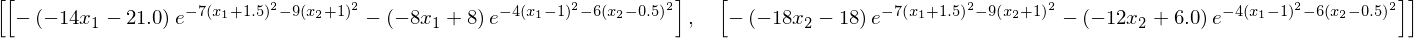


-----nn_hessian-----


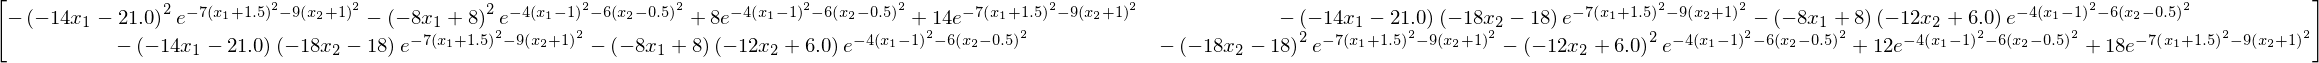

In [5]:
print '----' + 'nn' + '-----'
display(nn)
print
print '----' + 'nn_grad' + '----'
display(df_symbol)
print
print '-----' + 'nn_hessian' + '-----'
display(hes)
print
# print '-----' + 'X' + '-------'
# pprint(X)
# print

#### 全解探索

In [6]:
f_val = f([
    [interval[0.92, 1.08]],
    [interval[0.4, 0.56]]
])
print f_val[0][0]
print f_val[0][0][0].sup

interval([-1.0, -0.91796134233])
-0.91796134233


In [7]:
# x_1 = interval[-2, 2.2]
# x_2 = interval[-2, 2.2]

# x_1 = interval[0.2, 1.6]
# x_2 = interval[0.2, 1.6]

x_1 = interval[-2, 2.2]
x_2 = interval[-2, 2.2]


X = ip([[x_1],[x_2]])


kra = Krawczyk(df, ddf, X)

cnt_max = 2000
max_width = 1e-4
ans_boxes, S_num_list, T_num_list, U_num_list, animation_box = kra.find_global_minimum(f, trace=False, cnt_max=cnt_max, max_width=max_width)

# ans_boxes, S_num_list, T_num_list, U_num_list, animation_box = kra.find_global_minimum(
#     f, tmp_min_sup=f_val[0][0][0].sup ,trace=False, cnt_max=cnt_max, max_width=max_width)

# ans_boxes, S_num_list, T_num_list, U_num_list, animation_box = kra.find_all_solution(
#     trace=False, cnt_max=cnt_max, max_width=max_width)
print '#####'*10
pprint(ans_boxes)

Loop end. cnt:58, len(S):0, len(T):2, len(U):0

58
---------- 最終的なS[:10] -----------
[]
---------- 最終的なU[:10] -----------
[]
---------- 最終的なT -----------
[[[interval([0.9277982209500776, 1.0637092973968394])],
  [interval([0.44121317423192297, 0.5624273235297641])]],
 [[interval([-1.5138329212540778, -1.4756061434849985])],
  [interval([-1.0208580194594878, -0.9543756476556472])]]]
##################################################
[[[interval([0.9999999999999998, 1.0000000000000002])],
  [interval([0.4999999999999999, 0.5000000000000001])]],
 [[interval([-1.5000000000000002, -1.4999999999999996])],
  [interval([-1.0000000000000002, -0.9999999999999998])]]]


## 探索の可視化

In [8]:
_NO_SOLUTIONS_FLAG = '_NO_SOLUTIONS_FLAG'
_NO_MINMUM_FLAG = '_NO_MINMUM_FLAG'
_EXACT_1_SOLUTION_FLAG = '_EXACT_1_SOLUTION_FLAG'
_MULTI_SOLUTIONS_FLAG = '_MULTI_SOLUTIONS_FLAG'  # less than 1 solution
_UNCLEAR_SOLUTION_FLAG = '_UNCLEAR_SOLUTION_FLAG'

# facecolor, edgecolor
color_map ={
    _NO_SOLUTIONS_FLAG: ("#bbbbbb", "#000000"),
    _NO_MINMUM_FLAG: ("#ffffbb", "#000000"),    
    _UNCLEAR_SOLUTION_FLAG:("#ffffff", "#000000" ),
    _EXACT_1_SOLUTION_FLAG: ("#00ffff", "#00ffff"),
}

def get_rect(x_1, x_2, facecolor_code, edgecolor_code):
    left, right, below, above = x_1[0][0], x_1[0][1], x_2[0][0], x_2[0][1]
    rect = Rectangle((left, below),
                    right - left,
                    above - below,
                    facecolor= facecolor_code,
                    edgecolor=edgecolor_code
                    )
    return rect


print 'len(animation_box): {}'.format(len(animation_box))
x1_lim = animation_box[0][0][0][0][0][0]
x2_lim = animation_box[0][0][0][1][0][0]
print x1_lim
print x2_lim

len(animation_box): 58
(-2.0, 2.2)
(-2.0, 2.2)


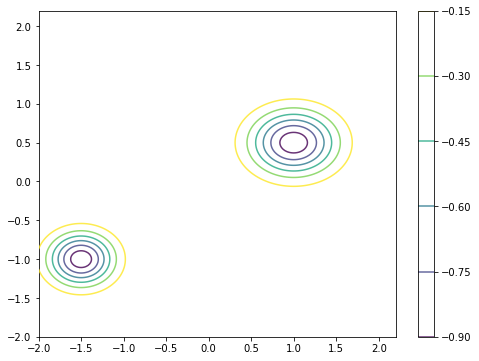

finish


In [11]:
x = np.arange(-2, 2, 0.02) 
y = np.arange(-2, 2, 0.02) 
X, Y = np.meshgrid(x, y)
Z = np.apply_along_axis(activate_func, 0, np.array([X.flatten(), Y.flatten()])).reshape(X.shape)
fig = plt.figure(figsize=(8,6))
plt.xlim(x1_lim)
plt.ylim(x2_lim)
im = plt.contour(X, Y, Z, alpha=0.8, zorder=100, shading='gouraud')
fig.colorbar(im)
plt.show()

now_string = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())
dirpath = 'image/{}'.format(now_string)
os.makedirs(dirpath)

for i in range(len(animation_box)):
#     if i % 7:
#         continue
        
    fig = plt.figure(figsize=(8,6))
    plt.title('find global minima, count: {}, tmp_min_sup: {}'.format(i, inf)) 
    plt.xlim(x1_lim)
    plt.ylim(x2_lim)
    ax = fig.add_subplot(111)
    for j in range(i+1):
        for parent_box, parent_flag in animation_box[j]:
#        parent_box, parent_flag = animation_box[j]
            fcolor, ecolor = color_map[parent_flag]# facecolor, edgecolor
            parent_x1 = parent_box[0][0]
            parent_x2 = parent_box[1][0]
            if ip.is_empty(parent_box):
                continue
            rect = get_rect(parent_x1, parent_x2, fcolor, ecolor)
            ax.add_patch(rect)
            
    # 最後にcolor mapを薄く重ねる    
    im =plt.contour(X, Y, Z, alpha=0.8, zorder=100, shading='gouraud')
    fig.colorbar(im)
    image_path = os.path.join(dirpath, "anime_{0:0>4}.png".format(i))
    fig.savefig(image_path)
    plt.close(fig)
    
print 'finish'

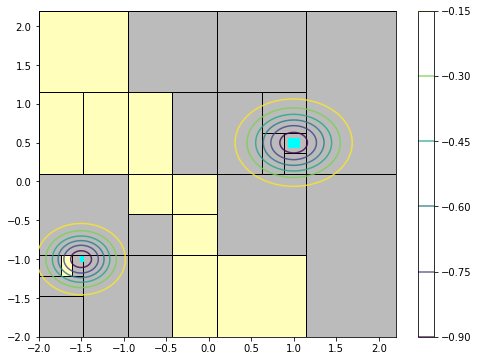

In [12]:
#最後の画像だけ表示

fig = plt.figure(figsize=(8,6))
plt.xlim(x1_lim)
plt.ylim(x2_lim)
ax = fig.add_subplot(111)
for j in range(len(animation_box)):
    for parent_box, parent_flag in animation_box[j]:
#        parent_box, parent_flag = animation_box[j]
        fcolor, ecolor = color_map[parent_flag]# facecolor, edgecolor
        parent_x1 = parent_box[0][0]
        parent_x2 = parent_box[1][0]
        if ip.is_empty(parent_box):
            continue
        rect = get_rect(parent_x1, parent_x2, fcolor, ecolor)
        ax.add_patch(rect)

# 最後にcolor mapを薄く重ねる    
im =plt.contour(X, Y, Z, alpha=0.8, zorder=100, shading='gouraud')
fig.colorbar(im)